In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [ ]:
import pandas as pd

# Loading the dataset(BF ROUTE)
file_path =r"/content/TMT_12MM_BF_Route.csv"
df_bf = pd.read_csv(file_path)


In [ ]:
# Rename column 'Price ' to 'Price'
df_bf.rename(columns={'Price ': 'Price'}, inplace=True)

# Verifying the column names
df_bf.columns.tolist()


['Date', 'Price']

DEBUG:cmdstanpy:input tempfile: /tmp/tmp01vguywv/mcyamxbs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp01vguywv/pnia59po.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19197', 'data', 'file=/tmp/tmp01vguywv/mcyamxbs.json', 'init=/tmp/tmp01vguywv/pnia59po.json', 'output', 'file=/tmp/tmp01vguywv/prophet_modelei1ne06c/prophet_model-20250711173757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


R²: 0.9418, RMSE: 548.6417


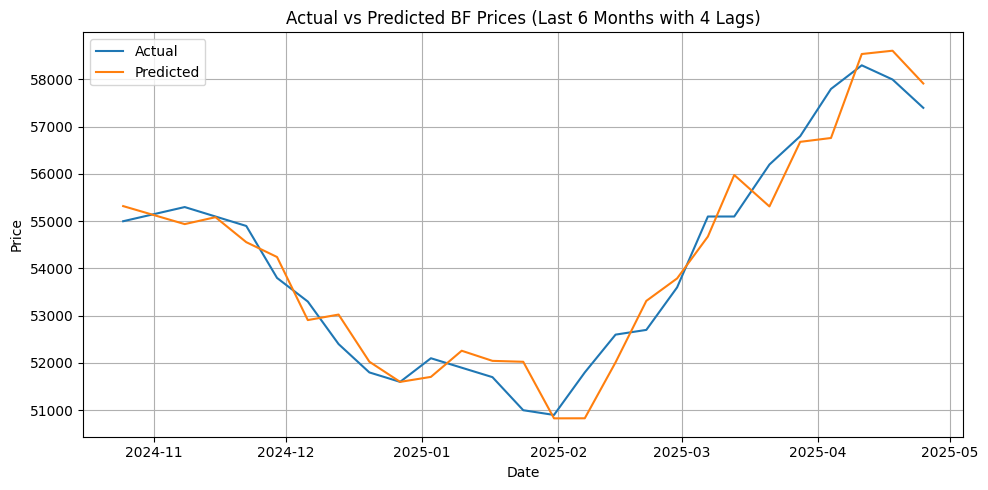

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Preprocess and Feature Engineering
df_bf['Date'] = pd.to_datetime(df_bf['Date'])
df_bf = df_bf.sort_values('Date')

# Create lag and rolling features
df_bf['Lag1'] = df_bf['Price '].shift(1)
df_bf['Lag2'] = df_bf['Price '].shift(2)
df_bf['Lag3'] = df_bf['Price '].shift(3)
df_bf['Lag4'] = df_bf['Price '].shift(4)
df_bf['Rolling7'] = df_bf['Price '].rolling(window=7).mean()
df_bf['Month'] = df_bf['Date'].dt.month
df_bf['Weekday'] = df_bf['Date'].dt.weekday
df_bf['is_monsoon'] = df_bf['Month'].between(6, 9).astype(int)

# Drop rows with NaN values from lagging/rolling
df_bf = df_bf.dropna()

# Rename for Prophet
prophet_df = df_bf.rename(columns={'Date': 'ds', 'Price ': 'y'})

# Step 2: Set up Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0
)

# Add custom monsoon seasonality and regressors
model.add_seasonality(name='monsoon_season', period=365.25, fourier_order=10)
model.add_regressor('Lag1')
model.add_regressor('Lag2')
model.add_regressor('Lag3')
model.add_regressor('Lag4')
model.add_regressor('Rolling7')
model.add_regressor('Month')
model.add_regressor('Weekday')
model.add_regressor('is_monsoon')

# Step 3: Fit the model
model.fit(prophet_df)

# Step 4: Prepare last 6 months for prediction
last_6_months = prophet_df[prophet_df['ds'] >= prophet_df['ds'].max() - pd.DateOffset(months=6)]

# Create future dataframe with all required features
future = last_6_months[['ds', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Rolling7', 'Month', 'Weekday', 'is_monsoon']].copy()

# Step 5: Predict
forecast = model.predict(future)

# Step 6: Merge actual and predicted
results = future.copy()
results['actual'] = last_6_months['y'].values
results['predicted'] = forecast['yhat'].values

# Step 7: Evaluate
r2 = r2_score(results['actual'], results['predicted'])
rmse = np.sqrt(mean_squared_error(results['actual'], results['predicted']))

print(f"R²: {r2:.4f}, RMSE: {rmse:.4f}")

# Step 8: Save to CSV
results.to_csv("last_6_months_predictions_with_4_lags_bf.csv", index=False)

# Step 9: Plot
plt.figure(figsize=(10, 5))
plt.plot(results['ds'], results['actual'], label='Actual')
plt.plot(results['ds'], results['predicted'], label='Predicted')
plt.title('Actual vs Predicted BF Prices (Last 6 Months with 4 Lags)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


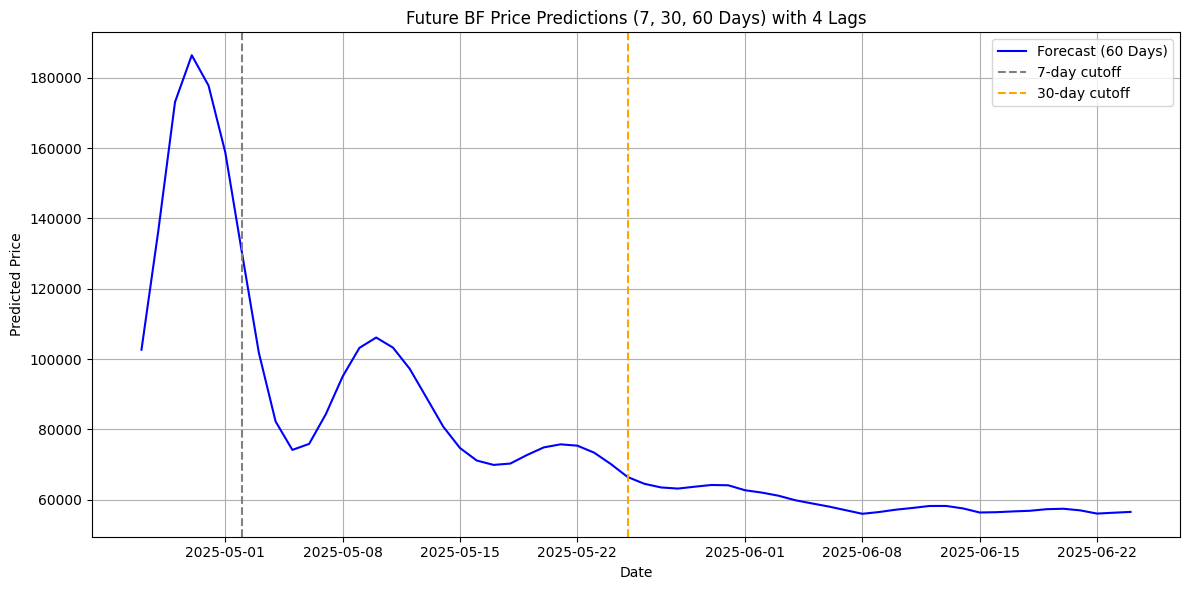

In [ ]:
# Starting point: last known row from bf training data
last_row = prophet_df.iloc[-1].copy()

# Generate future dates (60 days ahead)
future_dates = pd.date_range(start=last_row['ds'] + pd.Timedelta(days=1), periods=60, freq='D')
future_df = pd.DataFrame({'ds': future_dates})

# Use historical actual data to initialize
history = prophet_df[['ds', 'y']].copy().set_index('ds')
history_full = history.copy()

# Container for future forecasts
future_preds = []

# Recursive prediction loop
for date in future_dates:
    lag1 = history_full.loc[date - pd.Timedelta(days=1), 'y'] if (date - pd.Timedelta(days=1)) in history_full.index else np.nan
    lag2 = history_full.loc[date - pd.Timedelta(days=2), 'y'] if (date - pd.Timedelta(days=2)) in history_full.index else np.nan
    lag3 = history_full.loc[date - pd.Timedelta(days=3), 'y'] if (date - pd.Timedelta(days=3)) in history_full.index else np.nan
    lag4 = history_full.loc[date - pd.Timedelta(days=4), 'y'] if (date - pd.Timedelta(days=4)) in history_full.index else np.nan
    rolling7 = history_full.loc[history_full.index < date].tail(7)['y'].mean()

    month = date.month
    weekday = date.weekday()
    is_monsoon = int(month in [6, 7, 8, 9])

    # Create input features
    input_df = pd.DataFrame({
        'ds': [date],
        'Lag1': [lag1],
        'Lag2': [lag2],
        'Lag3': [lag3],
        'Lag4': [lag4],
        'Rolling7': [rolling7],
        'Month': [month],
        'Weekday': [weekday],
        'is_monsoon': [is_monsoon]
    })

    # Impute missing values
    input_df = input_df.fillna(0)

    # Forecast
    forecast = model.predict(input_df)
    yhat = forecast['yhat'].values[0]

    # Save prediction
    future_preds.append({'ds': date, 'predicted': yhat})

    # Update history
    history_full.loc[date] = {'y': yhat}
    history_full = history_full.sort_index()

# Final result
future_results = pd.DataFrame(future_preds)

# Save
future_results.to_csv('future_60_day_predictions_BF_with_4lags.csv', index=False)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(future_results['ds'], future_results['predicted'], label='Forecast (60 Days)', color='blue')
plt.axvline(future_results['ds'].iloc[6], color='gray', linestyle='--', label='7-day cutoff')
plt.axvline(future_results['ds'].iloc[29], color='orange', linestyle='--', label='30-day cutoff')
plt.title('Future BF Price Predictions (7, 30, 60 Days) with 4 Lags')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df_if = pd.read_csv('/content/TMT_12MM_IF_Route.csv')

DEBUG:cmdstanpy:input tempfile: /tmp/tmp01vguywv/dvmej1cm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp01vguywv/gvf0dn1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90087', 'data', 'file=/tmp/tmp01vguywv/dvmej1cm.json', 'init=/tmp/tmp01vguywv/gvf0dn1b.json', 'output', 'file=/tmp/tmp01vguywv/prophet_modelt5wecjkl/prophet_model-20250711174307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


R²: 0.9702, RMSE: 254.7861


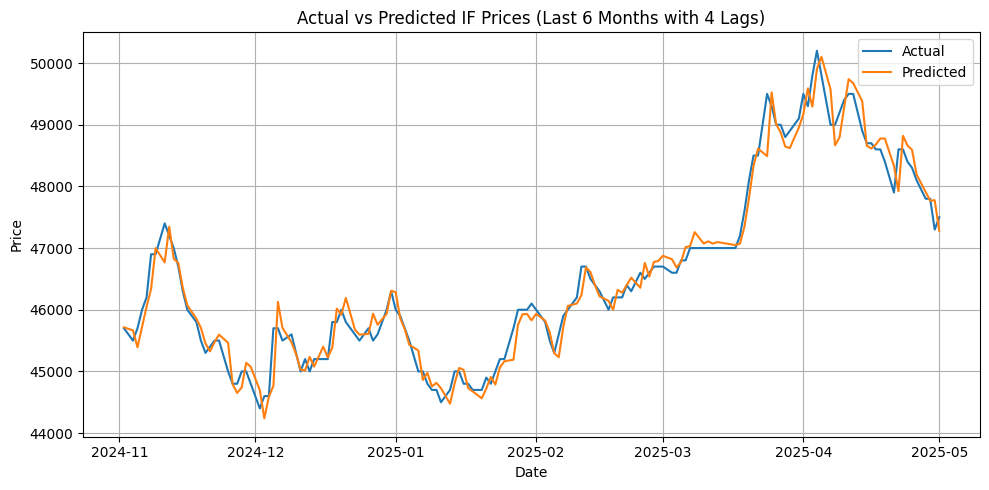

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Preprocess and Feature Engineering
df_if['Date'] = pd.to_datetime(df_if['Date'])
df_if = df_if.sort_values('Date')

# Create lag and rolling features
df_if['Lag1'] = df_if['Price '].shift(1)
df_if['Lag2'] = df_if['Price '].shift(2)
df_if['Lag3'] = df_if['Price '].shift(3)
df_if['Lag4'] = df_if['Price '].shift(4)
df_if['Rolling7'] = df_if['Price '].rolling(window=7).mean()
df_if['Month'] = df_if['Date'].dt.month
df_if['Weekday'] = df_if['Date'].dt.weekday
df_if['is_monsoon'] = df_if['Month'].between(6, 9).astype(int)

# Drop rows with NaN values from lagging/rolling
df_if = df_if.dropna()

# Rename for Prophet
prophet_df = df_if.rename(columns={'Date': 'ds', 'Price ': 'y'})

# Step 2: Set up Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0
)

# Add custom monsoon seasonality and regressors
model.add_seasonality(name='monsoon_season', period=365.25, fourier_order=10)
model.add_regressor('Lag1')
model.add_regressor('Lag2')
model.add_regressor('Lag3')
model.add_regressor('Lag4')
model.add_regressor('Rolling7')
model.add_regressor('Month')
model.add_regressor('Weekday')
model.add_regressor('is_monsoon')

# Step 3: Fit the model
model.fit(prophet_df)

# Step 4: Prepare last 6 months for prediction
last_6_months = prophet_df[prophet_df['ds'] >= prophet_df['ds'].max() - pd.DateOffset(months=6)]

# Create future dataframe with all required features
future = last_6_months[['ds', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Rolling7', 'Month', 'Weekday', 'is_monsoon']].copy()

# Step 5: Predict
forecast = model.predict(future)

# Step 6: Merge actual and predicted
results = future.copy()
results['actual'] = last_6_months['y'].values
results['predicted'] = forecast['yhat'].values

# Step 7: Evaluate
r2 = r2_score(results['actual'], results['predicted'])
rmse = np.sqrt(mean_squared_error(results['actual'], results['predicted']))

print(f"R²: {r2:.4f}, RMSE: {rmse:.4f}")

# Step 8: Save to CSV
results.to_csv("last_6_months_predictions_with_4_lags_if.csv", index=False)

# Step 9: Plot
plt.figure(figsize=(10, 5))
plt.plot(results['ds'], results['actual'], label='Actual')
plt.plot(results['ds'], results['predicted'], label='Predicted')
plt.title('Actual vs Predicted IF Prices (Last 6 Months with 4 Lags)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


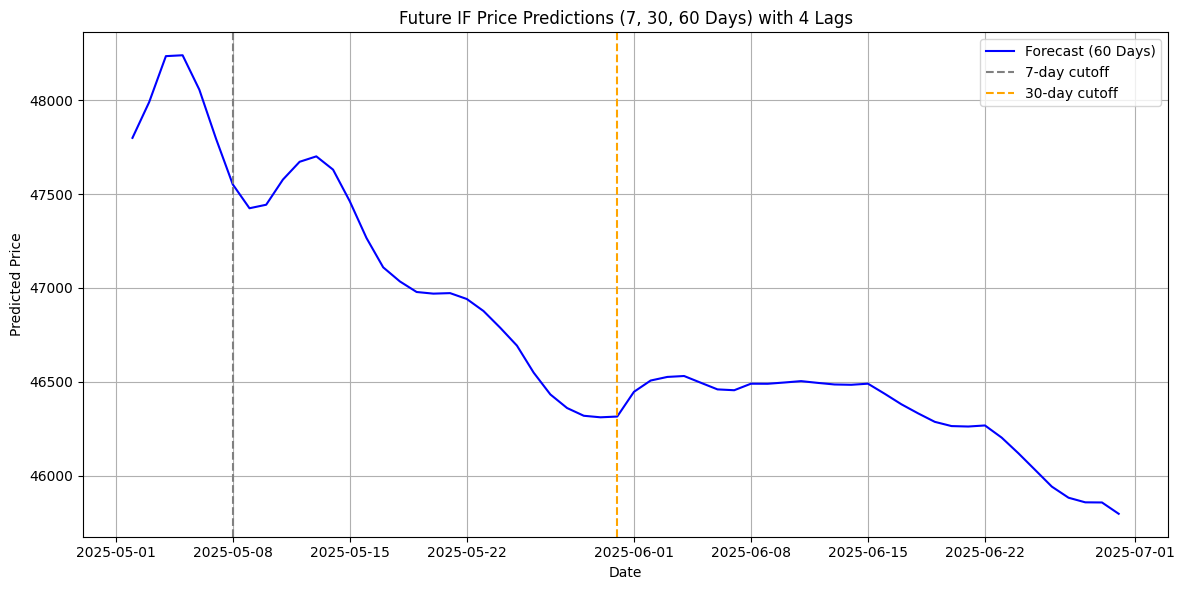

In [ ]:
# Starting point: last known row from IF training data
last_row = prophet_df.iloc[-1].copy()

# Generate future dates (60 days ahead)
future_dates = pd.date_range(start=last_row['ds'] + pd.Timedelta(days=1), periods=60, freq='D')
future_df = pd.DataFrame({'ds': future_dates})

# Use historical actual data to initialize
history = prophet_df[['ds', 'y']].copy().set_index('ds')
history_full = history.copy()

# Container for future forecasts
future_preds = []

# Recursive prediction loop
for date in future_dates:
    lag1 = history_full.loc[date - pd.Timedelta(days=1), 'y'] if (date - pd.Timedelta(days=1)) in history_full.index else np.nan
    lag2 = history_full.loc[date - pd.Timedelta(days=2), 'y'] if (date - pd.Timedelta(days=2)) in history_full.index else np.nan
    lag3 = history_full.loc[date - pd.Timedelta(days=3), 'y'] if (date - pd.Timedelta(days=3)) in history_full.index else np.nan
    lag4 = history_full.loc[date - pd.Timedelta(days=4), 'y'] if (date - pd.Timedelta(days=4)) in history_full.index else np.nan
    rolling7 = history_full.loc[history_full.index < date].tail(7)['y'].mean()

    month = date.month
    weekday = date.weekday()
    is_monsoon = int(month in [6, 7, 8, 9])

    # Create input features
    input_df = pd.DataFrame({
        'ds': [date],
        'Lag1': [lag1],
        'Lag2': [lag2],
        'Lag3': [lag3],
        'Lag4': [lag4],
        'Rolling7': [rolling7],
        'Month': [month],
        'Weekday': [weekday],
        'is_monsoon': [is_monsoon]
    })

    # Impute missing values
    input_df = input_df.fillna(0)

    # Forecast
    forecast = model.predict(input_df)
    yhat = forecast['yhat'].values[0]

    # Save prediction
    future_preds.append({'ds': date, 'predicted': yhat})

    # Update history with new prediction
    history_full.loc[date] = {'y': yhat}
    history_full = history_full.sort_index()

# Final result
future_results = pd.DataFrame(future_preds)

# Save
future_results.to_csv('future_60_day_predictions_IF_with_4lags.csv', index=False)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(future_results['ds'], future_results['predicted'], label='Forecast (60 Days)', color='blue')
plt.axvline(future_results['ds'].iloc[6], color='gray', linestyle='--', label='7-day cutoff')
plt.axvline(future_results['ds'].iloc[29], color='orange', linestyle='--', label='30-day cutoff')
plt.title('Future IF Price Predictions (7, 30, 60 Days) with 4 Lags')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
